In [1734]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
pd.options.display.float_format = '{:.4f}'.format

import pylab as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts

from sklearn.preprocessing import StandardScaler, MinMaxScaler  # normalizacion
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

#%matplotlib inline

from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Lasso        # regularizacion L1
from sklearn.linear_model import Ridge        # regularizacion L2
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import LogisticRegression as LogReg

from sklearn.svm import SVR

#!pip install xgboost
#!pip install catboost
#!pip install lightgbm
#!pip install h2o

from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.tree import ExtraTreeRegressor as ETR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
from catboost import CatBoostRegressor as CTR
from lightgbm import LGBMRegressor as LGBMR

import h2o
from h2o.automl import H2OAutoML

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge

In [1735]:
def machine_learning():
    
    modelos = {'LinReg':LinReg(), 'Lasso':Lasso(), 'Ridge':Ridge(), 'Elastic':ElasticNet(), 'RFR':RFR(), 
               'ETR':ETR(), 'SVR':SVR()
               ,'CTR':CTR() 
               ,'XGBR':XGBR() 
               ,'GBR':GBR() 
               ,'LGBMR':LGBMR()
               ,'RegBR':linear_model.BayesianRidge() 
               ,'SGD':SGDRegressor()
               ,'KerRid':KernelRidge()
              }
    
    nombres = ['LinReg', 'Lasso', 'Ridge', 'Elastic', 'RFR', 'ETR', 'SVR'
               ,'CTR'
               ,'XGBR'
               ,'GBR'
               ,'LGBMR'
               ,'RegBR' 
               , 'SGD'
               , 'KerRid'
              ]
    
    RMSE = []
    R2_test = []
    R2_train = []

    resumen_modelos = pd.DataFrame()

    for m in modelos:

        if m == 'CTR':
            
            mod = modelos[m]
            mod.fit(X_train, y_train, verbose=False)

            y_pred=mod.predict(X_test)
            error = mse(y_test, y_pred, squared=True)
            
            y_pred = mod.predict(X_test)
            R2_ts = mod.score(X_test, y_test)
            y_pred = mod.predict(X_train) 
            R2_tr = mod.score(X_train, y_train)

            RMSE.append(error)
            R2_test.append(R2_ts)
            R2_train.append(R2_tr)
            
        else:
            
            mod = modelos[m]
            mod.fit(X_train, y_train)

            y_pred=mod.predict(X_test)
            error = mse(y_test, y_pred, squared=True)
            
            y_pred = mod.predict(X_test)
            R2_ts = mod.score(X_test, y_test)
            y_pred = mod.predict(X_train) 
            R2_tr = mod.score(X_train, y_train)

            RMSE.append(error)
            R2_test.append(R2_ts)
            R2_train.append(R2_tr)

    resumen_modelos['Modelo'] = nombres
    resumen_modelos['RMSE'] = RMSE
    resumen_modelos['R2_test'] = R2_test
    resumen_modelos['R2_train'] = R2_train
    
    dict_errores = dict(zip(nombres, RMSE))
    best = list(dict_errores.keys())[list(dict_errores.values()).index(min(RMSE))] 
    
    modelo = modelos[best]
    
    modelo.fit(X_train, y_train)
    
    y_pred = modelo.predict(X_test)
    R2_test = modelo.score(X_test, y_test)
    y_pred = modelo.predict(X_train) 
    R2_train = modelo.score(X_train, y_train)
    
    error = min(RMSE)
    R2_train = round(R2_train, 4)
    R2_test = round(R2_test, 4)
    
    if R2_train > (1.15*R2_test):
        print(f'Best Model: {best}, RMSE = {error}, R2_train = {R2_train}, R2_test = {R2_test}, OVERFITING (modifica datos)')
    
    elif R2_train > R2_test:
        print(f'Best Model: {best}, RMSE = {error}, R2_train = {R2_train}, R2_test = {R2_test}, LO NORMAL')
    
    elif R2_train < R2_test:
        print(f'Best Model: {best}, RMSE = {error}, R2_train = {R2_train}, R2_test = {R2_test}, UNDERFITING (dame más datos)')
        
    return resumen_modelos

In [629]:
def get_outliers(data):
    stats = data.describe().T
    stats['IQR'] = stats['75%']-stats['25%']
    outliers = pd.DataFrame(columns=stats.index)
    for c in stats.index:
        iqr = stats.at[c, 'IQR']
        cut_off = 1.5 * iqr # test tukey
        lower = stats.at[c, '25%'] - cut_off
        upper = stats.at[c, '75%'] + cut_off
        res = data[(data[c] < lower) | (data[c] > upper)].copy()
        res['outliers'] = c
        outliers = outliers.append(res, sort=True)
    return outliers

### Cargamos tabla

In [743]:
data = pd.read_excel('../MASTERTABLA.xlsx')

In [744]:
covid_year = list(data[data['year']==2020].index) # Hay que eliminar datos de 2020, no se llegó a celebrar y salen puntos a 0
data.drop(covid_year, axis=0, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

### Limpieza

In [556]:
data.columns

Index(['key', 'country_id', 'country', 'artist', 'song', 'year', 'lyrics_long',
       'unic_words', 'vecinos_participantes', 'love_song', 'top1word',
       'top2word', 'top3word', 'top4word', 'top5word', 'estruc_resum',
       'finalista', 'puntos_corregidos', 'propo_max_puntos', 'clasificacion',
       'order_act', 'idioma1', 'idioma2', 'idioma3', 'views', 'likes', 'links',
       'estilos', 'shazams', 'duracion_spoty', 'duracion_eurovision', 'GDP',
       'orden_relativo_GDP', 'influ_ranking', 'influ_score', 'reput_ranking',
       'reput_sci_tech', 'reput_cult', 'reput_peace_secur',
       'reput_world_order', 'reput_planet_climate', 'reput_props_equal',
       'reput_health_wellbeing'],
      dtype='object')

In [745]:
invalid_columns = [#'key', #'puntos_corregidos', 'clasificacion', 'song',
                   'country_id', 'artist', 
                   'links', 'duracion_spoty', 'estruc_resum', 'finalista', 'idioma1', 'idioma2', 'idioma3', 
                   'lyrics_long', 'unic_words', 'vecinos_participantes','influ_score', 'influ_ranking',
                   'love_song','top1word', 'top2word', 'top3word', 'top4word', 'top5word', 'likes', 'estilos', 'GDP'
                  ]
data.drop(invalid_columns, axis=1, inplace=True) # Eliminamso columnas que no nos sirven para nuestro objetivo

In [746]:
# Todos los rankings de REPUTACIÓN están relacionados con reput_ranking (obviamente) y tienen baja corr. con los puntos. DROP
reput_cols = ['reput_sci_tech', 'reput_cult', 'reput_peace_secur','reput_world_order', 
              'reput_planet_climate', 'reput_props_equal','reput_health_wellbeing']
data.drop(reput_cols, axis=1, inplace=True)

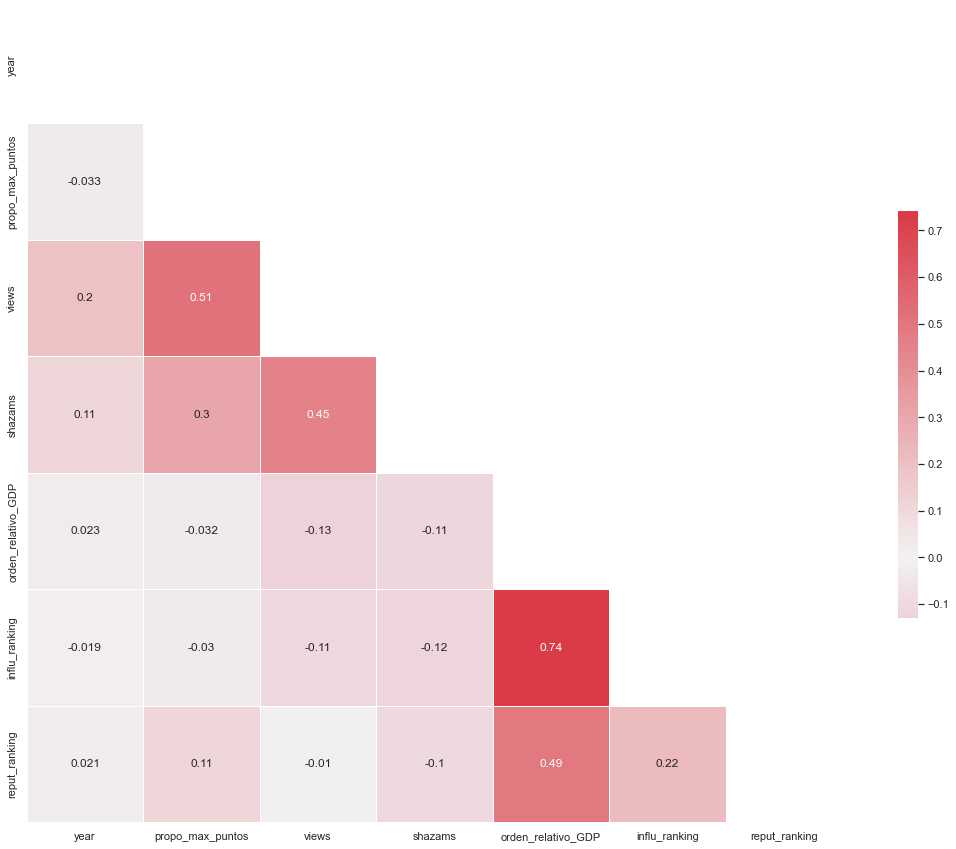

In [559]:
# buscando colinealidad

plt.figure(figsize=(20, 15))

sns.set(style='white')

mask=np.triu(np.ones_like(data.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(data.corr(),
          mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5, 
          cbar_kws={'shrink': 0.5});

### CORREGIMOS COLUMNAS

In [609]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 0 to 775
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              726 non-null    object 
 1   year                 726 non-null    int64  
 2   propo_max_puntos     726 non-null    float64
 3   order_act            456 non-null    float64
 4   views                726 non-null    float64
 5   shazams              726 non-null    float64
 6   duracion_eurovision  726 non-null    int64  
 7   orden_relativo_GDP   726 non-null    float64
 8   reput_ranking        726 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 56.7+ KB


In [747]:
# # Corrección love_song
# lista_corregida = []
# for e in data['love_song']:
#     if e == 'Yes':
#         lista_corregida.append(1)
#     else:
#         lista_corregida.append(0)
# data['love_song'] = lista_corregida

# Corrección propo_max_puntos
import math
lista_corregida = []
for e in data['propo_max_puntos']:
    if  math.isnan(e):
        lista_corregida.append(0)
    else:
        lista_corregida.append(e)
data['propo_max_puntos'] = lista_corregida

# Corrección puntos_corregidos
lista_corregida = []
for e in data['puntos_corregidos']:
    if  math.isnan(e):
        lista_corregida.append(0)
    else:
        lista_corregida.append(e)
data['puntos_corregidos'] = lista_corregida

# Corrección idioma1
# lista_corregida = []
# for e in data['idioma1']:

#     if  type(e) == str:
#         lista_corregida.append(e)
    
#     else:
#         lista_corregida.append('English') # FAKE DATA, pero es el idioma más común y mejor ponerlo como media que eliminar 300
# data['idioma1'] = lista_corregida

#Corrección estilos
# lista_corregida = []
# for estilo in data['estilos']:
#     if estilo == 'Indie':
#         lista_corregida.append('Alternative')
#     elif estilo == 'Hip-Hop':
#         lista_corregida.append('Hip-Hop/Rap')
#     elif estilo == 'Brazilian':
#         lista_corregida.append('Latino')
#     elif estilo == 'Brazilian':
#         lista_corregida.append('Latino')
#     elif estilo == 'Disco':
#         lista_corregida.append('Dance')
#     else:
#         lista_corregida.append(estilo)
# data['estilos'] = lista_corregida


#Corrección estilos
# top5estilos = list(data['estilos'].value_counts().index)[:5]
# lista_corregida = []
# for estilo in data['estilos']:
#     if estilo not in top5estilos:
#         lista_corregida.append('Others')
#     else:
#         lista_corregida.append(estilo)
# data['estilos'] = lista_corregida

#Corrección duración
lista_corregida = []
for dur in data['duracion_eurovision']:
    if type(dur) != str:
        if math.isnan(dur):
            lista_corregida.append(180)
    else:
        secs = (int(str(dur).split(':')[0]))*60 + int(str(dur).split(':')[1])
        lista_corregida.append(secs)
data['duracion_eurovision'] = lista_corregida

#Corrección order_act
lista_corregida = []
for g in data['order_act']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['order_act'].max()+1)
lista_corregida
data['order_act'] = lista_corregida

#Corrección GDP
# lista_corregida = []
# for g in data['GDP']:
#     if g > 0:
#         lista_corregida.append(g)
#     else:
#         lista_corregida.append(0)
        
# data['GDP'] = lista_corregida

#Corrección orden_relativo:GDP
lista_corregida = []
for g in data['orden_relativo_GDP']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['orden_relativo_GDP'].max()+1)
lista_corregida
data['orden_relativo_GDP'] = lista_corregida

#Corrección influ_score
# lista_corregida = []
# for g in data['influ_score']:
#     if g > 0:
#         lista_corregida.append(g)
#     else:
#         lista_corregida.append(0)
# lista_corregida
# data['influ_score'] = lista_corregida

#Corrección reput_ranking
lista_corregida = []
for g in data['reput_ranking']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['reput_ranking'].max()+1)
lista_corregida
data['reput_ranking'] = lista_corregida

#Corrección TODAS COLUMNAS REPUTACIÓN
# repu_columns = ['reput_sci_tech', 'reput_cult', 'reput_peace_secur','reput_world_order', 
#                 'reput_planet_climate', 'reput_props_equal','reput_health_wellbeing']

# for col in repu_columns:    # Como es exactamente la misma casuística para todas las columnas restantes, ¡bucle!
    
#     lista_corregida = []
#     for g in data[col]:
#         if g > 0:
#             lista_corregida.append(g)
#         else:
#             lista_corregida.append(data[col].max()+1)
#     data[col] = lista_corregida
    
#Corrección likes
# lista_corregida = []
# for l in data['likes']:
#     if 'M' in l:
#         lista_corregida.append(float(l.split(' M')[0].replace(',','.'))*1000000)
#     else:
#         lista_corregida.append(int(l))
        
# data['likes'] = lista_corregida

In [748]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  776 non-null    int64  
 1   country              776 non-null    object 
 2   song                 776 non-null    object 
 3   year                 776 non-null    int64  
 4   puntos_corregidos    776 non-null    float64
 5   propo_max_puntos     776 non-null    float64
 6   clasificacion        506 non-null    float64
 7   order_act            776 non-null    float64
 8   views                776 non-null    int64  
 9   shazams              776 non-null    int64  
 10  duracion_eurovision  776 non-null    int64  
 11  orden_relativo_GDP   776 non-null    float64
 12  reput_ranking        776 non-null    float64
dtypes: float64(6), int64(5), object(2)
memory usage: 78.9+ KB


### Calculamos proporciones para views, likes y shazams ("estandarizar" datos entre años)

In [739]:
data.groupby('year').sum()[['views','shazams']]

,views,shazams
year,,
2002,1731199,48537
2003,2586328,174680
2004,68324117,1025493
2005,15858259,577633
2006,87544674,645598
2007,81968785,694951
2008,34577048,262313
2009,39659076,6313893
2010,64932910,2925068


In [749]:
#Propos de PUNTOS
lista_corregida = []
dictio_participantes = dict(data.groupby('year').count()['country'])
for i,p in enumerate(data['puntos_corregidos']):
    lista_corregida.append(p / ((dictio_participantes[data['year'][i]]-1)*12) )
data['propo_puntos_bien'] = lista_corregida

#Propos de VIEWS
lista_corregida = []
dictio_views = dict(data.groupby('year').sum()['views'])
for i,v in enumerate(data['views']):
    lista_corregida.append(v/dictio_views[data['year'][i]])
data['views_propo'] = lista_corregida

#Propos de LIKES
# lista_corregida = []
# dictio_likes = dict(data.groupby('year').sum()['likes'])
# for i,v in enumerate(data['likes']):
#     lista_corregida.append(v/dictio_views[data['year'][i]])
# data['likes'] = lista_corregida

#Propos de YEAR
lista_corregida = []
dictio_views = dict(data.groupby('year').sum()['shazams'])
for i,v in enumerate(data['shazams']):
    lista_corregida.append(v/dictio_views[data['year'][i]])
data['shazams_propo'] = lista_corregida

data.head()

,key,country,song,year,puntos_corregidos,propo_max_puntos,clasificacion,order_act,views,shazams,duracion_eurovision,orden_relativo_GDP,reput_ranking,propo_puntos_bien,views_propo,shazams_propo
0,412011,North Macedonia,Rusinka (Русинкa),2011,0.0000,0.0000,NaN,28.0000,23210,0,176,29.0000,46.0000,0.0000,0.0043,0.0000
1,262009,France,Et s'il fallait le faire,2009,107.0000,0.2123,8.0000,3.0000,621785,11420,180,2.0000,11.0000,0.2175,0.0157,0.0018
2,522002,Spain,Europe's Living a Celebration,2002,81.0000,0.2812,7.0000,5.0000,23995,712,172,5.0000,18.0000,0.2935,0.0139,0.0147
3,402013,Montenegro,Igranka (Игранка),2013,0.0000,0.0000,NaN,28.0000,1017362,6202,174,45.0000,71.0000,0.0000,0.0215,0.0033
4,412007,North Macedonia,Mojot svet (Мојот свет),2007,73.0000,0.1448,14.0000,6.0000,334996,0,179,42.0000,46.0000,0.1484,0.0041,0.0000


In [750]:
no_youtube_years = list(data[data['year'].isin([2002, 2003])].index)
data.drop(no_youtube_years, axis=0, inplace=True)

### Cambiamos columnas categóricas a numéricas

In [620]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 0 to 775
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              726 non-null    object 
 1   year                 726 non-null    int64  
 2   propo_max_puntos     726 non-null    float64
 3   order_act            726 non-null    float64
 4   views                726 non-null    float64
 5   shazams              726 non-null    float64
 6   duracion_eurovision  726 non-null    int64  
 7   orden_relativo_GDP   726 non-null    float64
 8   reput_ranking        726 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 56.7+ KB


In [585]:
#NORMALIZAMOS

numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

scaler=StandardScaler()
data[numeric_cols]=scaler.fit_transform(data[numeric_cols])

In [621]:
# Label Encoder

for col in list(data.select_dtypes(exclude=["int64", 'float64']).columns):
    data[col] = LabelEncoder().fit_transform(data[col])

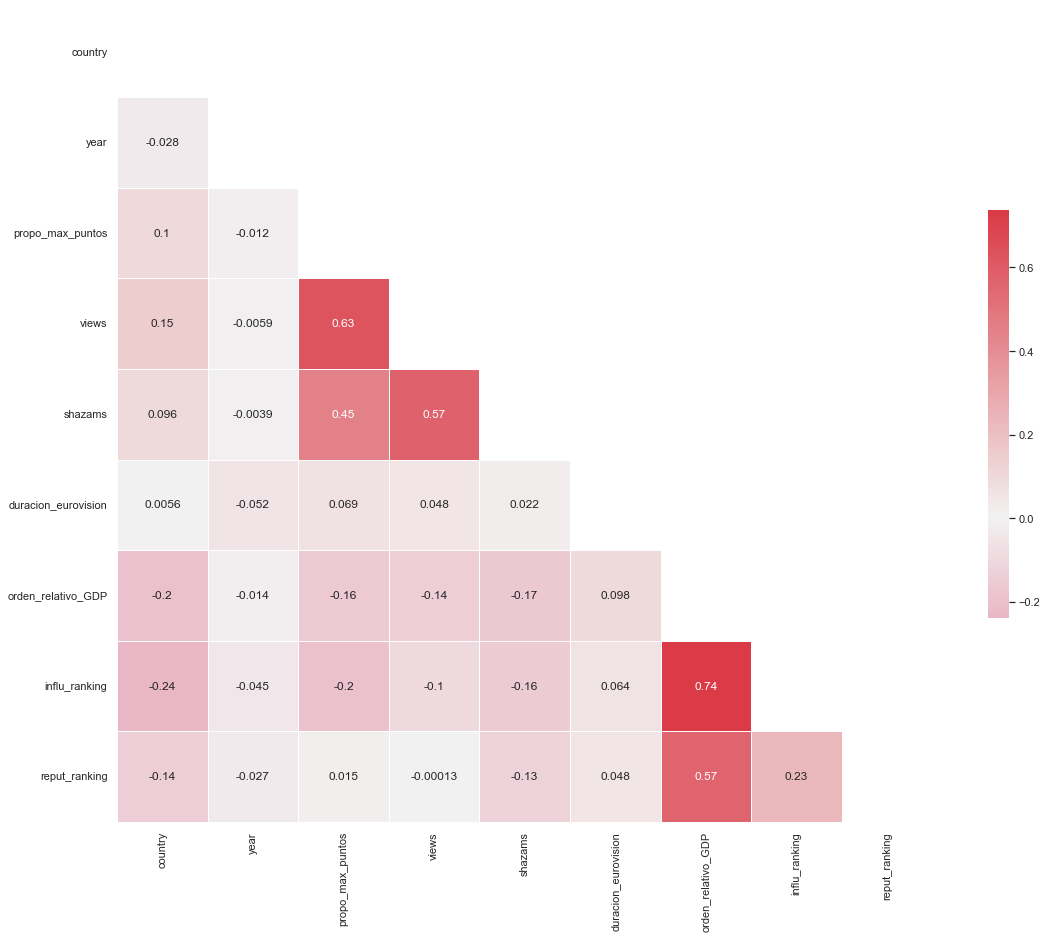

In [569]:
# buscando colinealidad

plt.figure(figsize=(20, 15))

sns.set(style='white')

mask=np.triu(np.ones_like(data.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(data.corr(),
          mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5, 
          cbar_kws={'shrink': 0.5});

In [570]:
data.columns

Index(['country', 'year', 'propo_max_puntos', 'views', 'shazams',
       'duracion_eurovision', 'orden_relativo_GDP', 'influ_ranking',
       'reput_ranking'],
      dtype='object')

In [627]:
X = data.drop('propo_max_puntos', axis=1)
y = data.propo_max_puntos

X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8, test_size=0.2, random_state=22)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((580, 8), (146, 8), (580,), (146,))

In [628]:
machine_learning()

Best Model: LinReg, RMSE = 0, R2_train = 0.4863, R2_test = 0.4748, LO NORMAL


,Modelo,RMSE,R2_test,R2_train
0,LinReg,0,0.4748,0.4863
1,Lasso,0,-0.0040,0.0000
2,Ridge,0,0.4430,0.4578
3,Elastic,0,-0.0040,0.0000
4,RFR,0,0.6812,0.9616
5,ETR,0,0.3477,1.0000
6,SVR,0,0.0405,0.0186
7,CTR,0,0.6678,0.9890
8,XGBR,0,0.5913,0.9999
9,GBR,0,0.6134,0.9057


In [360]:
CTR=CTR()
CTR.fit(X_train, y_train)
y_pred=CTR.predict(data)

Learning rate set to 0.037964
0:	learn: 0.1530104	total: 19.4ms	remaining: 19.4s
1:	learn: 0.1510194	total: 72.4ms	remaining: 36.1s
2:	learn: 0.1489649	total: 91.9ms	remaining: 30.5s
3:	learn: 0.1468349	total: 126ms	remaining: 31.4s
4:	learn: 0.1447631	total: 142ms	remaining: 28.3s
5:	learn: 0.1431385	total: 158ms	remaining: 26.2s
6:	learn: 0.1414752	total: 174ms	remaining: 24.7s
7:	learn: 0.1396460	total: 192ms	remaining: 23.8s
8:	learn: 0.1379052	total: 212ms	remaining: 23.3s
9:	learn: 0.1362376	total: 229ms	remaining: 22.7s
10:	learn: 0.1347610	total: 243ms	remaining: 21.9s
11:	learn: 0.1332365	total: 252ms	remaining: 20.7s
12:	learn: 0.1315376	total: 260ms	remaining: 19.7s
13:	learn: 0.1300904	total: 268ms	remaining: 18.9s
14:	learn: 0.1288647	total: 277ms	remaining: 18.2s
15:	learn: 0.1272479	total: 286ms	remaining: 17.6s
16:	learn: 0.1260269	total: 298ms	remaining: 17.2s
17:	learn: 0.1248858	total: 313ms	remaining: 17.1s
18:	learn: 0.1238670	total: 322ms	remaining: 16.6s
19:	lear

166:	learn: 0.0723783	total: 2.26s	remaining: 11.3s
167:	learn: 0.0722186	total: 2.28s	remaining: 11.3s
168:	learn: 0.0720433	total: 2.3s	remaining: 11.3s
169:	learn: 0.0719271	total: 2.31s	remaining: 11.3s
170:	learn: 0.0717663	total: 2.32s	remaining: 11.2s
171:	learn: 0.0716582	total: 2.33s	remaining: 11.2s
172:	learn: 0.0714888	total: 2.34s	remaining: 11.2s
173:	learn: 0.0713405	total: 2.35s	remaining: 11.2s
174:	learn: 0.0711798	total: 2.37s	remaining: 11.2s
175:	learn: 0.0710215	total: 2.39s	remaining: 11.2s
176:	learn: 0.0709392	total: 2.4s	remaining: 11.2s
177:	learn: 0.0708169	total: 2.42s	remaining: 11.2s
178:	learn: 0.0706565	total: 2.43s	remaining: 11.1s
179:	learn: 0.0704953	total: 2.45s	remaining: 11.2s
180:	learn: 0.0702778	total: 2.48s	remaining: 11.2s
181:	learn: 0.0701182	total: 2.54s	remaining: 11.4s
182:	learn: 0.0699845	total: 2.55s	remaining: 11.4s
183:	learn: 0.0698458	total: 2.57s	remaining: 11.4s
184:	learn: 0.0697168	total: 2.58s	remaining: 11.4s
185:	learn: 0.

343:	learn: 0.0514074	total: 4.13s	remaining: 7.88s
344:	learn: 0.0513005	total: 4.15s	remaining: 7.87s
345:	learn: 0.0512087	total: 4.16s	remaining: 7.87s
346:	learn: 0.0511277	total: 4.17s	remaining: 7.85s
347:	learn: 0.0509828	total: 4.18s	remaining: 7.83s
348:	learn: 0.0508830	total: 4.19s	remaining: 7.81s
349:	learn: 0.0507895	total: 4.2s	remaining: 7.8s
350:	learn: 0.0506478	total: 4.21s	remaining: 7.79s
351:	learn: 0.0505513	total: 4.22s	remaining: 7.77s
352:	learn: 0.0504584	total: 4.24s	remaining: 7.77s
353:	learn: 0.0503345	total: 4.25s	remaining: 7.75s
354:	learn: 0.0502619	total: 4.25s	remaining: 7.73s
355:	learn: 0.0502093	total: 4.26s	remaining: 7.71s
356:	learn: 0.0501106	total: 4.27s	remaining: 7.69s
357:	learn: 0.0499991	total: 4.28s	remaining: 7.67s
358:	learn: 0.0498559	total: 4.29s	remaining: 7.66s
359:	learn: 0.0497598	total: 4.29s	remaining: 7.64s
360:	learn: 0.0496786	total: 4.31s	remaining: 7.63s
361:	learn: 0.0496315	total: 4.33s	remaining: 7.63s
362:	learn: 0.

517:	learn: 0.0363907	total: 6.59s	remaining: 6.13s
518:	learn: 0.0363825	total: 6.6s	remaining: 6.12s
519:	learn: 0.0363314	total: 6.62s	remaining: 6.11s
520:	learn: 0.0362985	total: 6.63s	remaining: 6.1s
521:	learn: 0.0362813	total: 6.64s	remaining: 6.08s
522:	learn: 0.0362129	total: 6.65s	remaining: 6.07s
523:	learn: 0.0361111	total: 6.66s	remaining: 6.05s
524:	learn: 0.0360747	total: 6.67s	remaining: 6.03s
525:	learn: 0.0360100	total: 6.68s	remaining: 6.02s
526:	learn: 0.0358995	total: 6.69s	remaining: 6s
527:	learn: 0.0357943	total: 6.7s	remaining: 5.99s
528:	learn: 0.0357295	total: 6.7s	remaining: 5.97s
529:	learn: 0.0356945	total: 6.71s	remaining: 5.95s
530:	learn: 0.0356493	total: 6.72s	remaining: 5.94s
531:	learn: 0.0355227	total: 6.73s	remaining: 5.92s
532:	learn: 0.0354940	total: 6.74s	remaining: 5.9s
533:	learn: 0.0354170	total: 6.75s	remaining: 5.89s
534:	learn: 0.0353453	total: 6.75s	remaining: 5.87s
535:	learn: 0.0352429	total: 6.76s	remaining: 5.85s
536:	learn: 0.035155

682:	learn: 0.0275691	total: 9.6s	remaining: 4.45s
683:	learn: 0.0275256	total: 9.61s	remaining: 4.44s
684:	learn: 0.0274697	total: 9.63s	remaining: 4.43s
685:	learn: 0.0274314	total: 9.65s	remaining: 4.42s
686:	learn: 0.0273721	total: 9.66s	remaining: 4.4s
687:	learn: 0.0272773	total: 9.68s	remaining: 4.39s
688:	learn: 0.0272618	total: 9.7s	remaining: 4.38s
689:	learn: 0.0272251	total: 9.71s	remaining: 4.36s
690:	learn: 0.0271948	total: 9.73s	remaining: 4.35s
691:	learn: 0.0271785	total: 9.75s	remaining: 4.34s
692:	learn: 0.0271304	total: 9.76s	remaining: 4.33s
693:	learn: 0.0270936	total: 9.78s	remaining: 4.31s
694:	learn: 0.0270580	total: 9.8s	remaining: 4.3s
695:	learn: 0.0270111	total: 9.81s	remaining: 4.29s
696:	learn: 0.0269914	total: 9.83s	remaining: 4.27s
697:	learn: 0.0269829	total: 9.85s	remaining: 4.26s
698:	learn: 0.0269307	total: 9.86s	remaining: 4.25s
699:	learn: 0.0268544	total: 9.88s	remaining: 4.23s
700:	learn: 0.0267857	total: 9.9s	remaining: 4.22s
701:	learn: 0.0267

842:	learn: 0.0213915	total: 12.2s	remaining: 2.27s
843:	learn: 0.0213562	total: 12.2s	remaining: 2.26s
844:	learn: 0.0213298	total: 12.2s	remaining: 2.24s
845:	learn: 0.0213080	total: 12.2s	remaining: 2.23s
846:	learn: 0.0212584	total: 12.3s	remaining: 2.22s
847:	learn: 0.0212079	total: 12.3s	remaining: 2.21s
848:	learn: 0.0211723	total: 12.3s	remaining: 2.2s
849:	learn: 0.0211373	total: 12.4s	remaining: 2.18s
850:	learn: 0.0210990	total: 12.4s	remaining: 2.17s
851:	learn: 0.0210653	total: 12.4s	remaining: 2.16s
852:	learn: 0.0210381	total: 12.4s	remaining: 2.14s
853:	learn: 0.0210169	total: 12.4s	remaining: 2.13s
854:	learn: 0.0209808	total: 12.5s	remaining: 2.11s
855:	learn: 0.0209436	total: 12.5s	remaining: 2.1s
856:	learn: 0.0209419	total: 12.5s	remaining: 2.08s
857:	learn: 0.0209376	total: 12.5s	remaining: 2.07s
858:	learn: 0.0209094	total: 12.5s	remaining: 2.05s
859:	learn: 0.0208761	total: 12.5s	remaining: 2.04s
860:	learn: 0.0208259	total: 12.6s	remaining: 2.03s
861:	learn: 0.

In [369]:
chequeo = list(y_test.index)

In [363]:
data['predict'] = y_pred

In [380]:
data.iloc[chequeo]

,country,lyrics_long,unic_words,vecinos_participantes,love_song,top1word,top2word,top3word,top4word,top5word,propo_max_puntos,idioma1,views,likes,estilos,shazams,duracion_eurovision,GDP,orden_relativo_GDP,influ_score,reput_ranking,predict
333,14,1168,71,2,1,12,175,312,333,145,0.0000,9,0.0083,0.0000,4,0.0006,180,21.0900,37.0000,0.0000,28.0000,0.0287
417,22,1797,99,1,1,173,294,182,178,155,0.0000,9,0.0020,0.0000,4,0.0001,179,240.4540,18.0000,57.1200,7.0000,0.0055
427,7,1335,84,3,0,201,233,116,178,178,0.1806,9,0.0167,0.0001,4,0.0118,171,473.5240,13.0000,57.9600,13.0000,0.1182
144,19,1077,52,4,1,187,135,113,54,19,0.2883,9,0.0150,0.0002,4,0.0168,180,307.7090,16.0000,72.3300,26.0000,0.1229
610,34,932,85,1,1,237,158,34,158,81,0.0000,9,0.0169,0.0003,4,0.0008,180,227.4530,20.0000,68.0400,24.0000,0.0647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,14,1185,89,2,1,231,59,227,341,188,0.0000,9,0.0008,0.0000,5,0.0008,177,19.5730,36.0000,0.0000,28.0000,0.0089
30,42,1351,71,2,1,188,13,201,128,53,0.0060,65,0.0391,0.0002,4,0.0040,180,1318.8300,5.0000,78.7200,18.0000,0.1534
150,28,811,68,2,1,103,94,67,349,319,0.2163,9,0.0028,0.0000,4,0.0000,179,3.5710,44.0000,0.0000,31.0000,0.0079
203,46,1548,84,4,1,173,98,327,175,261,0.3512,9,0.3804,0.0028,4,0.0514,180,593.5330,9.0000,71.7800,38.0000,0.4179


In [624]:
data.columns

Index(['country', 'year', 'propo_max_puntos', 'order_act', 'views', 'shazams',
       'duracion_eurovision', 'orden_relativo_GDP', 'reput_ranking'],
      dtype='object')

In [626]:
# varias variables
x=sm.add_constant(data[[
        'country', 
        #'propo_max_puntos',
        'order_act',
        'views', 
        'shazams',
        'duracion_eurovision',
        'orden_relativo_GDP', 
        'reput_ranking'
    
]].apply(lambda x: x.fillna(x.mean()))

)

y=data['propo_max_puntos']


modelo=sm.OLS(y, x).fit()
pred=modelo.predict(x)
modelo.summary()

# Podemos eliminar varias columnas: vecinos_participantes, top5word, estilos, duracion_eurovision, GDP

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       propo_max_puntos   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     96.86
Date:                Thu, 29 Sep 2022   Prob (F-statistic):           2.64e-99
Time:                        13:22:09   Log-Likelihood:                 562.85
No. Observations:                 726   AIC:                            -1110.
Df Residuals:                     718   BIC:                            -1073.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0117      0.143     -0.082      0.935      -0.292       0.268
country              9.586e-05      0.000      0.309      0.757      -0.001       0.001
order_act              -0.0045      0.000     -9.824      0.000      -0.005      -0.004
views                   1.3840      0.092     15.015      0.000       1.203       1.565
shazams                 0.2393      0.060      3.969      0.000       0.121       0.358
duracion_eurovision     0.0010      0.001      1.237      0.216      -0.001       0.003
orden_relativo_GDP     -0.0009      0.000     -2.396      0.017      -0.002      -0.000
reput_ranking           0.0006      0.000      2.907      0.004       0.000       0.001
==============================================================================
Omnibus:                      149.719   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              445.349
Skew:                           1.003   Prob(JB):                     1.97e-97
Kurtosis:                       6.271   Cond. No.                     6.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Empezamos de nuevo con otro flujo y estrategias

In [1751]:
data = pd.read_excel('../MASTERTABLA.xlsx')
apuestas = pd.read_excel('../Apuestas_TOTAL.xlsx')

In [1752]:
covid_year = list(data[data['year']==2020].index) # Hay que eliminar datos de 2020, no se llegó a celebrar y salen puntos a 0
data.drop(covid_year, axis=0, inplace=True)
no_youtube_years = list(data[data['year'].isin([2002, 2003])].index)
data.drop(no_youtube_years, axis=0, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
apuestas.drop('Columna1', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
apuestas.rename(columns = {'codigo':'key'}, inplace = True)
apuestas.drop('country', axis=1, inplace=True)
data = data.merge(apuestas, on='key', how='left')

### Limpieza

In [1753]:
# Corrección love_song
lista_corregida = []
for e in data['love_song']:
    if e == 'Yes':
        lista_corregida.append(1)
    else:
        lista_corregida.append(0)
data['love_song'] = lista_corregida

# Corrección propo_max_puntos
import math
lista_corregida = []
for e in data['propo_max_puntos']:
    if  math.isnan(e):
        lista_corregida.append(0)
    else:
        lista_corregida.append(e)
data['propo_max_puntos'] = lista_corregida

# Corrección puntos_corregidos
lista_corregida = []
for e in data['puntos_corregidos']:
    if  math.isnan(e):
        lista_corregida.append(0)
    else:
        lista_corregida.append(e)
data['puntos_corregidos'] = lista_corregida

# Corrección idioma1
lista_corregida = []
for e in data['idioma1']:

    if  type(e) == str:
        lista_corregida.append(e)
    
    else:
        lista_corregida.append('English') # FAKE DATA, pero es el idioma más común y mejor ponerlo como media que eliminar 300
data['idioma1'] = lista_corregida

#Corrección estilos
lista_corregida = []
for estilo in data['estilos']:
    if estilo == 'Indie':
        lista_corregida.append('Alternative')
    elif estilo == 'Hip-Hop':
        lista_corregida.append('Hip-Hop/Rap')
    elif estilo == 'Brazilian':
        lista_corregida.append('Latino')
    elif estilo == 'Brazilian':
        lista_corregida.append('Latino')
    elif estilo == 'Disco':
        lista_corregida.append('Dance')
    else:
        lista_corregida.append(estilo)
data['estilos'] = lista_corregida


#Corrección estilos
top5estilos = list(data['estilos'].value_counts().index)[:5]
lista_corregida = []
for estilo in data['estilos']:
    if estilo not in top5estilos:
        lista_corregida.append('Others')
    else:
        lista_corregida.append(estilo)
data['estilos'] = lista_corregida

#Corrección duración
lista_corregida = []
for dur in data['duracion_eurovision']:
    if type(dur) != str:
        if math.isnan(dur):
            lista_corregida.append(180)
    else:
        secs = (int(str(dur).split(':')[0]))*60 + int(str(dur).split(':')[1])
        lista_corregida.append(secs)
data['duracion_eurovision'] = lista_corregida

#Corrección order_act
lista_corregida = []
for g in data['order_act']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['order_act'].max()+1)
lista_corregida
data['order_act'] = lista_corregida

#Corrección GDP
lista_corregida = []
for g in data['GDP']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(0)
        
data['GDP'] = lista_corregida

#Corrección orden_relativo:GDP
lista_corregida = []
for g in data['orden_relativo_GDP']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['orden_relativo_GDP'].max()+1)
lista_corregida
data['orden_relativo_GDP'] = lista_corregida

#Corrección influ_score
lista_corregida = []
for g in data['influ_score']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(0)
lista_corregida
data['influ_score'] = lista_corregida

#Corrección reput_ranking
lista_corregida = []
for g in data['reput_ranking']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['reput_ranking'].max()+1)
lista_corregida
data['reput_ranking'] = lista_corregida

#Corrección TODAS COLUMNAS REPUTACIÓN
repu_columns = ['reput_sci_tech', 'reput_cult', 'reput_peace_secur','reput_world_order', 
                'reput_planet_climate', 'reput_props_equal','reput_health_wellbeing']

for col in repu_columns:    # Como es exactamente la misma casuística para todas las columnas restantes, ¡bucle!
    lista_corregida = []
    for g in data[col]:
        if g > 0:
            lista_corregida.append(g)
        else:
            lista_corregida.append(data[col].max()+1)
    data[col] = lista_corregida
    
#Corrección likes
lista_corregida = []
for l in data['likes']:
    if 'M' in l:
        lista_corregida.append(float(l.split(' M')[0].replace(',','.'))*1000000)
    else:
        lista_corregida.append(int(l))
        
data['likes'] = lista_corregida

#Propos de PUNTOS
lista_corregida = []
dictio_participantes = dict(data.groupby('year').count()['country'])
for i,p in enumerate(data['puntos_corregidos']):
    lista_corregida.append(p / ((dictio_participantes[data['year'][i]]-1)*12) )
data['propo_puntos'] = lista_corregida

#Propos de VIEWS
lista_corregida = []
dictio_views = dict(data.groupby('year').sum()['views'])
for i,v in enumerate(data['views']):
    lista_corregida.append(v/dictio_views[data['year'][i]])
data['views_propos'] = lista_corregida

#Propos de LIKES
lista_corregida = []
dictio_likes = dict(data.groupby('year').sum()['likes'])
for i,v in enumerate(data['likes']):
    lista_corregida.append(v/dictio_likes[data['year'][i]])
data['likes_propos'] = lista_corregida

#Propos de YEAR
lista_corregida = []
dictio_views = dict(data.groupby('year').sum()['shazams'])
for i,v in enumerate(data['shazams']):
    lista_corregida.append(v/dictio_views[data['year'][i]])
data['shazams_propos'] = lista_corregida

lista_corregida = []
for orden in data['order_act']:
    if orden < 13:
        lista_corregida.append(1)
    else:
        lista_corregida.append(2)
data['half_act'] = lista_corregida

data.head()

,key,country_id,country,artist,song,year,lyrics_long,unic_words,vecinos_participantes,love_song,top1word,top2word,top3word,top4word,top5word,estruc_resum,finalista,puntos_corregidos,propo_max_puntos,clasificacion,order_act,idioma1,idioma2,idioma3,views,likes,links,estilos,shazams,duracion_spoty,duracion_eurovision,GDP,orden_relativo_GDP,influ_ranking,influ_score,reput_ranking,reput_sci_tech,reput_cult,reput_peace_secur,reput_world_order,reput_planet_climate,reput_props_equal,reput_health_wellbeing,bet_mean,propo_puntos,views_propos,likes_propos,shazams_propos,half_act
0,412011,41,North Macedonia,Vlatko Ilievski,Rusinka (Русинкa),2011,789,44,4,1,kakalin,kamaja,understand,learn,music,UNKNOWN,NO,0.0000,0.0000,NaN,28.0000,English,NaN,NaN,23210,208.0000,https://www.youtube.com/watch?v=LBgSn2rsGAA&li...,Pop,0,2:56,176,0.0000,29.0000,NaN,0.0000,46.0000,19.0000,55.0000,135.0000,54.0000,65.0000,74.0000,34.0000,550.0000,0.0000,0.0043,0.0028,0.0000,2
1,262009,26,France,Patricia Kaas,Et s'il fallait le faire,2009,1208,122,5,1,want,stop,great,stay,blow,UNKNOWN,SI,107.0000,0.2123,8.0000,3.0000,French,French,None,621785,6401.0000,https://www.youtube.com/watch?v=6gee9Qh6iVg&li...,Pop,11420,3:00,180,2634.8200,2.0000,3.0000,95.2600,11.0000,24.0000,14.0000,53.0000,16.0000,3.0000,17.0000,23.0000,26.0000,0.2175,0.0157,0.0136,0.0018,1
2,402013,40,Montenegro,Who See,Igranka (Игранка),2013,2058,190,3,1,dance,come,beat,let,night,UNKNOWN,NO,0.0000,0.0000,NaN,28.0000,English,NaN,NaN,1017362,11753.0000,https://www.youtube.com/watch?v=FR9rtB2ilZU&li...,Others,6202,2:54,174,0.0000,45.0000,NaN,0.0000,71.0000,48.0000,61.0000,128.0000,41.0000,91.0000,71.0000,134.0000,550.0000,0.0000,0.0215,0.0330,0.0033,2
3,412007,41,North Macedonia,Karolina (2),Mojot svet (Мојот свет),2007,896,49,4,1,know,mean,bro,money,want,IVPEVPE,SI,73.0000,0.1448,14.0000,6.0000,"Macedonian, English",Macedonian,English,334996,1562.0000,https://www.youtube.com/watch?v=TBPcvkEqTG8&li...,Pop,0,2:59,179,7.0200,42.0000,NaN,0.0000,46.0000,19.0000,55.0000,135.0000,54.0000,65.0000,74.0000,34.0000,21.0000,0.1484,0.0041,0.0022,0.0000,1
4,522013,52,Spain,ESDM,Contigo hasta el final,2013,527,54,1,1,end,light,universe,invite,travel,UNKNOWN,SI,8.0000,0.0171,25.0000,5.0000,Spanish,Spanish,None,1127751,5342.0000,https://www.youtube.com/watch?v=5o_DnM_ANF8&li...,Pop,11303,3:05,180,1534.0100,6.0000,7.0000,78.7200,18.0000,40.0000,30.0000,70.0000,15.0000,9.0000,34.0000,22.0000,500.0000,0.0175,0.0238,0.0150,0.0061,1


## Outliers 
##### Consideraremos registros RAROS aquellos que tengan más viasualizaciones/likes de lo normal en YouTube y no hayan conseguido más proporción de puntos de la habitual (media últimos 18 años)
### Debe cumplirse (1+2+3):
#### 1. Propo_views > Propo_views.mean(DEL PAÍS 2004_2022)
#### 2. Propo_likes > Propo_likes.mean(DEL PAÍS 2004_2022)
#### 3. Propo_puntos < Propo_puntos.mean(DEL PAÍS 2004_2022) * o el 80% de la media, para dar un margen.

In [1754]:
data.groupby('country').mean()[['views_propos', 'likes_propos', 'propo_puntos']]
dictio_views_mean = dict(data.groupby('country').mean()['views_propos'])
dictio_likes_mean = dict(data.groupby('country').mean()['likes_propos'])
dictio_puntos_mean = dict(data.groupby('country').mean()['propo_puntos'])

lista_raros = []
for i,e in enumerate(data['views_propos']):
    if (e > dictio_views_mean[data['country'][i]]) and (data['likes_propos'][i] > dictio_likes_mean[data['country'][i]]) and data['propo_puntos'][i] < dictio_puntos_mean[data['country'][i]]:
        lista_raros.append('raros')
    else:
        lista_raros.append('normal')
data['raros'] = lista_raros

outliers = list(data[data['raros']=='raros'].index)

data.drop(outliers, axis=0, inplace=True)

### Buscamos outliers con DBScan

In [1755]:
data.head()

,key,country_id,country,artist,song,year,lyrics_long,unic_words,vecinos_participantes,love_song,top1word,top2word,top3word,top4word,top5word,estruc_resum,finalista,puntos_corregidos,propo_max_puntos,clasificacion,order_act,idioma1,idioma2,idioma3,views,likes,links,estilos,shazams,duracion_spoty,duracion_eurovision,GDP,orden_relativo_GDP,influ_ranking,influ_score,reput_ranking,reput_sci_tech,reput_cult,reput_peace_secur,reput_world_order,reput_planet_climate,reput_props_equal,reput_health_wellbeing,bet_mean,propo_puntos,views_propos,likes_propos,shazams_propos,half_act,raros
0,412011,41,North Macedonia,Vlatko Ilievski,Rusinka (Русинкa),2011,789,44,4,1,kakalin,kamaja,understand,learn,music,UNKNOWN,NO,0.0000,0.0000,NaN,28.0000,English,NaN,NaN,23210,208.0000,https://www.youtube.com/watch?v=LBgSn2rsGAA&li...,Pop,0,2:56,176,0.0000,29.0000,NaN,0.0000,46.0000,19.0000,55.0000,135.0000,54.0000,65.0000,74.0000,34.0000,550.0000,0.0000,0.0043,0.0028,0.0000,2,normal
1,262009,26,France,Patricia Kaas,Et s'il fallait le faire,2009,1208,122,5,1,want,stop,great,stay,blow,UNKNOWN,SI,107.0000,0.2123,8.0000,3.0000,French,French,None,621785,6401.0000,https://www.youtube.com/watch?v=6gee9Qh6iVg&li...,Pop,11420,3:00,180,2634.8200,2.0000,3.0000,95.2600,11.0000,24.0000,14.0000,53.0000,16.0000,3.0000,17.0000,23.0000,26.0000,0.2175,0.0157,0.0136,0.0018,1,normal
3,412007,41,North Macedonia,Karolina (2),Mojot svet (Мојот свет),2007,896,49,4,1,know,mean,bro,money,want,IVPEVPE,SI,73.0000,0.1448,14.0000,6.0000,"Macedonian, English",Macedonian,English,334996,1562.0000,https://www.youtube.com/watch?v=TBPcvkEqTG8&li...,Pop,0,2:59,179,7.0200,42.0000,NaN,0.0000,46.0000,19.0000,55.0000,135.0000,54.0000,65.0000,74.0000,34.0000,21.0000,0.1484,0.0041,0.0022,0.0000,1,normal
4,522013,52,Spain,ESDM,Contigo hasta el final,2013,527,54,1,1,end,light,universe,invite,travel,UNKNOWN,SI,8.0000,0.0171,25.0000,5.0000,Spanish,Spanish,None,1127751,5342.0000,https://www.youtube.com/watch?v=5o_DnM_ANF8&li...,Pop,11303,3:05,180,1534.0100,6.0000,7.0000,78.7200,18.0000,40.0000,30.0000,70.0000,15.0000,9.0000,34.0000,22.0000,500.0000,0.0175,0.0238,0.0150,0.0061,1,normal
5,102018,10,Albania,Eugent Bushpepa,Mall,2018,1208,127,3,1,feel,dream,moment,stop,sweet,UNKNOWN,SI,92.0000,0.1783,11.0000,12.0000,Albanian,Albanian,None,1192629,17681.0000,https://www.youtube.com/watch?v=uyl1b1fVmdU&li...,Pop,5741,3:10,180,14.3410,40.0000,NaN,0.0000,45.0000,28.0000,33.0000,84.0000,45.0000,132.0000,6.0000,106.0000,321.3333,0.1825,0.0064,0.0089,0.0012,1,normal


In [1474]:
data_copy = data.copy()

In [1477]:
elim_cols = ['key', 'country_id', 'artist', 'song', 'year', 'lyrics_long',
       'unic_words', 'vecinos_participantes', 'love_song', 'top1word',
       'top2word', 'top3word', 'top4word', 'top5word', 'estruc_resum',
       'finalista', 'puntos_corregidos', 'propo_max_puntos', 'clasificacion',
       'order_act', 'idioma1', 'idioma2', 'idioma3', 'views', 'likes', 'links',
       'estilos', 'shazams', 'duracion_spoty', 'duracion_eurovision', 'GDP',
       'orden_relativo_GDP', 'influ_ranking', 'influ_score', 'reput_ranking',
       'reput_sci_tech', 'reput_cult', 'reput_peace_secur',
       'reput_world_order', 'reput_planet_climate', 'reput_props_equal',
       'reput_health_wellbeing', 'half_act']

In [1478]:
data_copy.drop(elim_cols, axis=1, inplace=True)

In [1479]:
data_copy.head()

,country,propo_puntos,views_propos,likes_propos,shazams_propos
0,North Macedonia,0.0000,0.0043,0.0028,0.0000
1,France,0.2175,0.0157,0.0136,0.0018
2,Montenegro,0.0000,0.0215,0.0330,0.0033
3,North Macedonia,0.1484,0.0041,0.0022,0.0000
4,Spain,0.0175,0.0238,0.0150,0.0061


In [1480]:
# Label Encoder
for col in list(data_copy.select_dtypes(exclude=["int64", 'float64']).columns):
    data_copy[col] = LabelEncoder().fit_transform(data_copy[col])

In [1481]:
from sklearn.cluster import DBSCAN 

dbscan=DBSCAN(eps=0.5)

dbscan.fit(data_copy)

DBSCAN()

In [1482]:
labels_DBSCAN = dbscan.labels_
len(labels_DBSCAN)

726

In [1483]:
data_copy['DBSCAN_labels'] = labels_DBSCAN

In [1484]:
data_copy['song'] = list(data['song'])

In [1485]:
data_copy[data_copy['DBSCAN_labels'] == -1] 

#Encuentra como outliers valores que arrasaron o se hudieron, pero me interesa que los aprenda. Nos quedamos con nuestra lógica

,country,propo_puntos,views_propos,likes_propos,shazams_propos,DBSCAN_labels,song
79,19,0.5044,0.3048,0.1997,0.7068,-1,My Number One
93,15,0.6759,0.5499,0.5568,0.1989,-1,Hard Rock Hallelujah
175,32,0.7866,0.1680,0.4287,0.8725,-1,Fairytale
232,40,0.0000,0.0064,0.0058,0.0012,-1,I'm Still Alive
262,43,0.7561,0.4288,0.3548,0.6708,-1,Euphoria
265,40,0.0000,0.0038,0.0033,0.0000,-1,Don't Close Your Eyes
306,45,0.5509,0.0310,0.0250,0.4404,-1,Calm After the Storm
484,45,0.5188,0.2226,0.2598,0.8540,-1,Arcade
559,47,0.4776,0.5090,0.5645,0.6906,-1,Dancing Lasha Tumbai (Данцінґ Лаша Тумбай)
579,40,0.0000,0.0004,0.0002,0.0000,-1,Leť tmou


In [1486]:
out_dbscan = list(data_copy[data_copy['DBSCAN_labels'] == -1].index)

In [1488]:
data.drop(out_dbscan, axis=0, inplace=True) #Comprobado, eliminar outliers de DBScan empeora el resultado.

### Transformamos columnas

In [1756]:
columnas_elim = ['key', 'country_id',  'artist', 'song', 'year', 
                 'lyrics_long','unic_words', 'vecinos_participantes', 'love_song', 'top1word',
                 'top2word', 'top3word', 'top4word', 'top5word', 'estruc_resum',
                 'finalista', 'puntos_corregidos', 'propo_max_puntos', 'clasificacion',
                 'idioma1', 
                 'idioma2', 'idioma3', 'views', 'likes', 'links','GDP',
                 'estilos', 
                 'shazams', 'duracion_spoty', 
                 'duracion_eurovision', 
                 'orden_relativo_GDP', 'influ_ranking', 'influ_score', 'reput_ranking',
                 'reput_sci_tech', 'reput_cult', 'reput_peace_secur','reput_world_order', 
                 'reput_planet_climate', 'reput_props_equal','reput_health_wellbeing', 'half_act',
                 #'propo_puntos' 
                 #'views_propos',
                 #'likes_propos', 
                 #'shazams_propos',
                 'order_act',
                 'raros'
                 #'country',
                 #'bet_mean'
                ]
data.drop(columnas_elim, axis=1, inplace=True)

In [1661]:
# NORMALIZAMOS
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
scaler=StandardScaler()
data[numeric_cols]=scaler.fit_transform(data[numeric_cols]) # NO, EMPEORA EL RESULTADO. NONSENSE

In [1744]:
# Label Encoder
for col in list(data.select_dtypes(exclude=["int64", 'float64']).columns):
    data[col] = LabelEncoder().fit_transform(data[col])

In [1674]:
# Get Dummies
cols_categoricas = list(data.select_dtypes(exclude=["int64", 'float64']).columns)
data = pd.get_dummies(data, columns=cols_categoricas, drop_first = True)

In [1745]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 725
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         683 non-null    int32  
 1   bet_mean        683 non-null    float64
 2   propo_puntos    683 non-null    float64
 3   views_propos    683 non-null    float64
 4   likes_propos    683 non-null    float64
 5   shazams_propos  683 non-null    float64
dtypes: float64(5), int32(1)
memory usage: 34.7 KB


In [1749]:
data.to_excel('../Data_to_train.xlsx')

### Feature Impotances

In [1726]:
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

# dtr
X=data.drop(columns=['propo_puntos'])
y=data.propo_puntos

dtr=DTR().fit(X, y)

dict(zip(X.columns, dtr.feature_importances_))

sum(dtr.feature_importances_)

X_norm=StandardScaler().fit_transform(X)
dtr=DTR().fit(X_norm, y)

dict(zip(X.columns, dtr.feature_importances_))

rfr=RFR(n_estimators=2000).fit(X_norm, y)

dict(zip(X.columns, rfr.feature_importances_))   # de media

{'country': 0.038694155230101654,
 'bet_mean': 0.26412400947554365,
 'views_propos': 0.06939107349426514,
 'likes_propos': 0.5741088228096326,
 'shazams_propos': 0.05368193899045693}

#### Con toto (725 datos) explicamos el 83% con (likes, bet_mean, shzm, views, country)

### Probamos machine_learning

In [1746]:
X = data.drop('propo_puntos', axis=1)
y = data.propo_puntos

X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8, test_size=0.2, random_state=22)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((546, 5), (137, 5), (546,), (137,))

In [1747]:
machine_learning()

Learning rate set to 0.03721
0:	learn: 0.1535468	total: 6.2ms	remaining: 6.2s
1:	learn: 0.1500793	total: 11.5ms	remaining: 5.72s
2:	learn: 0.1468687	total: 19.8ms	remaining: 6.58s
3:	learn: 0.1439962	total: 25.7ms	remaining: 6.39s
4:	learn: 0.1406755	total: 32ms	remaining: 6.36s
5:	learn: 0.1376197	total: 37.6ms	remaining: 6.23s
6:	learn: 0.1350956	total: 44ms	remaining: 6.24s
7:	learn: 0.1324663	total: 50ms	remaining: 6.21s
8:	learn: 0.1298809	total: 56.1ms	remaining: 6.18s
9:	learn: 0.1272444	total: 78.5ms	remaining: 7.77s
10:	learn: 0.1250221	total: 84.5ms	remaining: 7.6s
11:	learn: 0.1226144	total: 90.6ms	remaining: 7.46s
12:	learn: 0.1204280	total: 97.6ms	remaining: 7.41s
13:	learn: 0.1180800	total: 104ms	remaining: 7.31s
14:	learn: 0.1161282	total: 120ms	remaining: 7.86s
15:	learn: 0.1140794	total: 125ms	remaining: 7.71s
16:	learn: 0.1123567	total: 131ms	remaining: 7.56s
17:	learn: 0.1109270	total: 137ms	remaining: 7.45s
18:	learn: 0.1091328	total: 142ms	remaining: 7.35s
19:	lear

181:	learn: 0.0547041	total: 1.18s	remaining: 5.3s
182:	learn: 0.0546271	total: 1.19s	remaining: 5.29s
183:	learn: 0.0545818	total: 1.19s	remaining: 5.29s
184:	learn: 0.0544786	total: 1.2s	remaining: 5.28s
185:	learn: 0.0544207	total: 1.2s	remaining: 5.27s
186:	learn: 0.0543512	total: 1.21s	remaining: 5.26s
187:	learn: 0.0542726	total: 1.22s	remaining: 5.25s
188:	learn: 0.0541621	total: 1.22s	remaining: 5.24s
189:	learn: 0.0540895	total: 1.24s	remaining: 5.27s
190:	learn: 0.0540326	total: 1.24s	remaining: 5.25s
191:	learn: 0.0539077	total: 1.24s	remaining: 5.23s
192:	learn: 0.0537892	total: 1.25s	remaining: 5.21s
193:	learn: 0.0536115	total: 1.25s	remaining: 5.19s
194:	learn: 0.0535464	total: 1.25s	remaining: 5.17s
195:	learn: 0.0534131	total: 1.26s	remaining: 5.16s
196:	learn: 0.0533115	total: 1.26s	remaining: 5.15s
197:	learn: 0.0532526	total: 1.27s	remaining: 5.13s
198:	learn: 0.0531575	total: 1.27s	remaining: 5.11s
199:	learn: 0.0531042	total: 1.27s	remaining: 5.09s
200:	learn: 0.0

360:	learn: 0.0414893	total: 1.99s	remaining: 3.53s
361:	learn: 0.0414444	total: 2s	remaining: 3.53s
362:	learn: 0.0413635	total: 2.01s	remaining: 3.52s
363:	learn: 0.0412351	total: 2.01s	remaining: 3.52s
364:	learn: 0.0412123	total: 2.02s	remaining: 3.51s
365:	learn: 0.0412021	total: 2.02s	remaining: 3.51s
366:	learn: 0.0411415	total: 2.03s	remaining: 3.5s
367:	learn: 0.0411315	total: 2.04s	remaining: 3.5s
368:	learn: 0.0410099	total: 2.04s	remaining: 3.5s
369:	learn: 0.0409327	total: 2.05s	remaining: 3.49s
370:	learn: 0.0409108	total: 2.05s	remaining: 3.48s
371:	learn: 0.0408896	total: 2.06s	remaining: 3.47s
372:	learn: 0.0407885	total: 2.06s	remaining: 3.47s
373:	learn: 0.0407790	total: 2.06s	remaining: 3.46s
374:	learn: 0.0407271	total: 2.07s	remaining: 3.45s
375:	learn: 0.0406102	total: 2.07s	remaining: 3.44s
376:	learn: 0.0405988	total: 2.08s	remaining: 3.43s
377:	learn: 0.0405350	total: 2.08s	remaining: 3.42s
378:	learn: 0.0404935	total: 2.08s	remaining: 3.41s
379:	learn: 0.0404

521:	learn: 0.0326531	total: 2.82s	remaining: 2.58s
522:	learn: 0.0326382	total: 2.84s	remaining: 2.59s
523:	learn: 0.0326112	total: 2.84s	remaining: 2.58s
524:	learn: 0.0325641	total: 2.85s	remaining: 2.58s
525:	learn: 0.0325368	total: 2.85s	remaining: 2.57s
526:	learn: 0.0324671	total: 2.86s	remaining: 2.57s
527:	learn: 0.0323924	total: 2.87s	remaining: 2.56s
528:	learn: 0.0323515	total: 2.89s	remaining: 2.57s
529:	learn: 0.0323276	total: 2.9s	remaining: 2.57s
530:	learn: 0.0323240	total: 2.9s	remaining: 2.56s
531:	learn: 0.0323027	total: 2.91s	remaining: 2.56s
532:	learn: 0.0322605	total: 2.92s	remaining: 2.56s
533:	learn: 0.0321890	total: 2.92s	remaining: 2.55s
534:	learn: 0.0321522	total: 2.93s	remaining: 2.54s
535:	learn: 0.0321318	total: 2.93s	remaining: 2.54s
536:	learn: 0.0321084	total: 2.93s	remaining: 2.53s
537:	learn: 0.0320739	total: 2.94s	remaining: 2.52s
538:	learn: 0.0320534	total: 2.94s	remaining: 2.52s
539:	learn: 0.0319769	total: 2.94s	remaining: 2.51s
540:	learn: 0.

701:	learn: 0.0255805	total: 3.63s	remaining: 1.54s
702:	learn: 0.0255440	total: 3.64s	remaining: 1.54s
703:	learn: 0.0254958	total: 3.65s	remaining: 1.53s
704:	learn: 0.0254541	total: 3.65s	remaining: 1.53s
705:	learn: 0.0254321	total: 3.66s	remaining: 1.52s
706:	learn: 0.0253937	total: 3.66s	remaining: 1.52s
707:	learn: 0.0253631	total: 3.67s	remaining: 1.51s
708:	learn: 0.0253177	total: 3.68s	remaining: 1.51s
709:	learn: 0.0252931	total: 3.68s	remaining: 1.5s
710:	learn: 0.0252648	total: 3.69s	remaining: 1.5s
711:	learn: 0.0252527	total: 3.69s	remaining: 1.49s
712:	learn: 0.0252196	total: 3.69s	remaining: 1.49s
713:	learn: 0.0252004	total: 3.7s	remaining: 1.48s
714:	learn: 0.0251630	total: 3.7s	remaining: 1.48s
715:	learn: 0.0251288	total: 3.71s	remaining: 1.47s
716:	learn: 0.0251075	total: 3.71s	remaining: 1.46s
717:	learn: 0.0250530	total: 3.71s	remaining: 1.46s
718:	learn: 0.0250308	total: 3.72s	remaining: 1.45s
719:	learn: 0.0250110	total: 3.72s	remaining: 1.45s
720:	learn: 0.02

891:	learn: 0.0206909	total: 4.46s	remaining: 540ms
892:	learn: 0.0206559	total: 4.47s	remaining: 536ms
893:	learn: 0.0206461	total: 4.47s	remaining: 531ms
894:	learn: 0.0206323	total: 4.48s	remaining: 526ms
895:	learn: 0.0205688	total: 4.49s	remaining: 521ms
896:	learn: 0.0205306	total: 4.49s	remaining: 516ms
897:	learn: 0.0205075	total: 4.5s	remaining: 511ms
898:	learn: 0.0204947	total: 4.5s	remaining: 506ms
899:	learn: 0.0204443	total: 4.51s	remaining: 501ms
900:	learn: 0.0204060	total: 4.51s	remaining: 496ms
901:	learn: 0.0203885	total: 4.52s	remaining: 491ms
902:	learn: 0.0203665	total: 4.52s	remaining: 486ms
903:	learn: 0.0203415	total: 4.53s	remaining: 481ms
904:	learn: 0.0203165	total: 4.53s	remaining: 475ms
905:	learn: 0.0203002	total: 4.53s	remaining: 470ms
906:	learn: 0.0202720	total: 4.54s	remaining: 465ms
907:	learn: 0.0202646	total: 4.54s	remaining: 460ms
908:	learn: 0.0202405	total: 4.54s	remaining: 455ms
909:	learn: 0.0202089	total: 4.54s	remaining: 450ms
910:	learn: 0.

,Modelo,RMSE,R2_test,R2_train
0,LinReg,0.0096,0.6987,0.6260
1,Lasso,0.0192,0.3982,0.4094
2,Ridge,0.0104,0.6761,0.6151
3,Elastic,0.0192,0.4005,0.4100
4,RFR,0.0072,0.7757,0.9640
5,ETR,0.0160,0.4997,1.0000
6,SVR,0.0209,0.3460,0.3483
7,CTR,0.0071,0.7773,0.9861
8,XGBR,0.0082,0.7435,0.9999
9,GBR,0.0089,0.7210,0.9274


### Eliminando Outliers, sin 2002/2003, con Apuestas (con Label)
#### 0'99 - 0'78 // 0.007 de error (CTR)

### Predecimos

In [1748]:
ctr=CTR()
ctr.fit(X_train, y_train)
y_pred=ctr.predict(X_test)

Learning rate set to 0.03721
0:	learn: 0.1535468	total: 6.05ms	remaining: 6.04s
1:	learn: 0.1500793	total: 13.1ms	remaining: 6.56s
2:	learn: 0.1468687	total: 19.1ms	remaining: 6.34s
3:	learn: 0.1439962	total: 30.8ms	remaining: 7.67s
4:	learn: 0.1406755	total: 36.3ms	remaining: 7.21s
5:	learn: 0.1376197	total: 50.5ms	remaining: 8.36s
6:	learn: 0.1350956	total: 57.9ms	remaining: 8.22s
7:	learn: 0.1324663	total: 63.7ms	remaining: 7.89s
8:	learn: 0.1298809	total: 70.8ms	remaining: 7.79s
9:	learn: 0.1272444	total: 103ms	remaining: 10.2s
10:	learn: 0.1250221	total: 111ms	remaining: 9.94s
11:	learn: 0.1226144	total: 116ms	remaining: 9.54s
12:	learn: 0.1204280	total: 123ms	remaining: 9.33s
13:	learn: 0.1180800	total: 128ms	remaining: 9.05s
14:	learn: 0.1161282	total: 141ms	remaining: 9.28s
15:	learn: 0.1140794	total: 147ms	remaining: 9.07s
16:	learn: 0.1123567	total: 154ms	remaining: 8.9s
17:	learn: 0.1109270	total: 160ms	remaining: 8.73s
18:	learn: 0.1091328	total: 166ms	remaining: 8.59s
19:	

176:	learn: 0.0550829	total: 991ms	remaining: 4.61s
177:	learn: 0.0549815	total: 997ms	remaining: 4.6s
178:	learn: 0.0549103	total: 1s	remaining: 4.6s
179:	learn: 0.0548649	total: 1.01s	remaining: 4.59s
180:	learn: 0.0547592	total: 1.02s	remaining: 4.63s
181:	learn: 0.0547041	total: 1.03s	remaining: 4.62s
182:	learn: 0.0546271	total: 1.03s	remaining: 4.62s
183:	learn: 0.0545818	total: 1.04s	remaining: 4.61s
184:	learn: 0.0544786	total: 1.05s	remaining: 4.61s
185:	learn: 0.0544207	total: 1.06s	remaining: 4.63s
186:	learn: 0.0543512	total: 1.06s	remaining: 4.63s
187:	learn: 0.0542726	total: 1.07s	remaining: 4.62s
188:	learn: 0.0541621	total: 1.08s	remaining: 4.62s
189:	learn: 0.0540895	total: 1.08s	remaining: 4.61s
190:	learn: 0.0540326	total: 1.09s	remaining: 4.61s
191:	learn: 0.0539077	total: 1.1s	remaining: 4.62s
192:	learn: 0.0537892	total: 1.1s	remaining: 4.62s
193:	learn: 0.0536115	total: 1.11s	remaining: 4.61s
194:	learn: 0.0535464	total: 1.11s	remaining: 4.61s
195:	learn: 0.05341

348:	learn: 0.0420677	total: 2.16s	remaining: 4.03s
349:	learn: 0.0419951	total: 2.17s	remaining: 4.03s
350:	learn: 0.0419691	total: 2.18s	remaining: 4.03s
351:	learn: 0.0419272	total: 2.19s	remaining: 4.03s
352:	learn: 0.0418272	total: 2.2s	remaining: 4.03s
353:	learn: 0.0418025	total: 2.21s	remaining: 4.03s
354:	learn: 0.0417913	total: 2.21s	remaining: 4.02s
355:	learn: 0.0417804	total: 2.23s	remaining: 4.03s
356:	learn: 0.0417142	total: 2.24s	remaining: 4.04s
357:	learn: 0.0416584	total: 2.26s	remaining: 4.05s
358:	learn: 0.0416350	total: 2.29s	remaining: 4.08s
359:	learn: 0.0415483	total: 2.3s	remaining: 4.08s
360:	learn: 0.0414893	total: 2.31s	remaining: 4.08s
361:	learn: 0.0414444	total: 2.31s	remaining: 4.08s
362:	learn: 0.0413635	total: 2.33s	remaining: 4.08s
363:	learn: 0.0412351	total: 2.35s	remaining: 4.1s
364:	learn: 0.0412123	total: 2.35s	remaining: 4.1s
365:	learn: 0.0412021	total: 2.36s	remaining: 4.09s
366:	learn: 0.0411415	total: 2.37s	remaining: 4.09s
367:	learn: 0.04

528:	learn: 0.0323515	total: 3.68s	remaining: 3.27s
529:	learn: 0.0323276	total: 3.69s	remaining: 3.27s
530:	learn: 0.0323240	total: 3.7s	remaining: 3.26s
531:	learn: 0.0323027	total: 3.7s	remaining: 3.26s
532:	learn: 0.0322605	total: 3.71s	remaining: 3.25s
533:	learn: 0.0321890	total: 3.71s	remaining: 3.24s
534:	learn: 0.0321522	total: 3.72s	remaining: 3.23s
535:	learn: 0.0321318	total: 3.73s	remaining: 3.23s
536:	learn: 0.0321084	total: 3.73s	remaining: 3.22s
537:	learn: 0.0320739	total: 3.74s	remaining: 3.21s
538:	learn: 0.0320534	total: 3.75s	remaining: 3.21s
539:	learn: 0.0319769	total: 3.76s	remaining: 3.2s
540:	learn: 0.0319074	total: 3.77s	remaining: 3.2s
541:	learn: 0.0318373	total: 3.77s	remaining: 3.19s
542:	learn: 0.0317677	total: 3.78s	remaining: 3.18s
543:	learn: 0.0317044	total: 3.79s	remaining: 3.17s
544:	learn: 0.0316455	total: 3.79s	remaining: 3.17s
545:	learn: 0.0316168	total: 3.8s	remaining: 3.16s
546:	learn: 0.0315891	total: 3.81s	remaining: 3.15s
547:	learn: 0.031

710:	learn: 0.0252648	total: 5.27s	remaining: 2.14s
711:	learn: 0.0252527	total: 5.28s	remaining: 2.13s
712:	learn: 0.0252196	total: 5.28s	remaining: 2.13s
713:	learn: 0.0252004	total: 5.3s	remaining: 2.12s
714:	learn: 0.0251630	total: 5.31s	remaining: 2.12s
715:	learn: 0.0251288	total: 5.32s	remaining: 2.11s
716:	learn: 0.0251075	total: 5.32s	remaining: 2.1s
717:	learn: 0.0250530	total: 5.33s	remaining: 2.09s
718:	learn: 0.0250308	total: 5.34s	remaining: 2.09s
719:	learn: 0.0250110	total: 5.35s	remaining: 2.08s
720:	learn: 0.0249886	total: 5.35s	remaining: 2.07s
721:	learn: 0.0249769	total: 5.36s	remaining: 2.06s
722:	learn: 0.0249654	total: 5.36s	remaining: 2.05s
723:	learn: 0.0249384	total: 5.37s	remaining: 2.05s
724:	learn: 0.0249056	total: 5.38s	remaining: 2.04s
725:	learn: 0.0248829	total: 5.38s	remaining: 2.03s
726:	learn: 0.0248594	total: 5.39s	remaining: 2.02s
727:	learn: 0.0248031	total: 5.39s	remaining: 2.02s
728:	learn: 0.0247720	total: 5.4s	remaining: 2.01s
729:	learn: 0.0

881:	learn: 0.0208982	total: 6.51s	remaining: 871ms
882:	learn: 0.0208847	total: 6.51s	remaining: 863ms
883:	learn: 0.0208706	total: 6.52s	remaining: 856ms
884:	learn: 0.0208623	total: 6.54s	remaining: 850ms
885:	learn: 0.0208338	total: 6.55s	remaining: 843ms
886:	learn: 0.0207855	total: 6.56s	remaining: 836ms
887:	learn: 0.0207801	total: 6.57s	remaining: 828ms
888:	learn: 0.0207510	total: 6.57s	remaining: 821ms
889:	learn: 0.0207458	total: 6.58s	remaining: 813ms
890:	learn: 0.0207290	total: 6.59s	remaining: 806ms
891:	learn: 0.0206909	total: 6.59s	remaining: 798ms
892:	learn: 0.0206559	total: 6.6s	remaining: 791ms
893:	learn: 0.0206461	total: 6.61s	remaining: 783ms
894:	learn: 0.0206323	total: 6.61s	remaining: 776ms
895:	learn: 0.0205688	total: 6.62s	remaining: 768ms
896:	learn: 0.0205306	total: 6.62s	remaining: 761ms
897:	learn: 0.0205075	total: 6.63s	remaining: 753ms
898:	learn: 0.0204947	total: 6.64s	remaining: 746ms
899:	learn: 0.0204443	total: 6.64s	remaining: 738ms
900:	learn: 0

In [1704]:
len(y_pred)

137

### Unimos a data para comprobar

In [1706]:
data = pd.read_excel('../MASTERTABLA.xlsx')
apuestas = pd.read_excel('../Apuestas_TOTAL.xlsx')

covid_year = list(data[data['year']==2020].index) # Hay que eliminar datos de 2020, no se llegó a celebrar y salen puntos a 0
data.drop(covid_year, axis=0, inplace=True)
no_youtube_years = list(data[data['year'].isin([2002, 2003])].index)
data.drop(no_youtube_years, axis=0, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
apuestas.drop('Columna1', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
apuestas.rename(columns = {'codigo':'key'}, inplace = True)
apuestas.drop('country', axis=1, inplace=True)
data = data.merge(apuestas, on='key', how='left')

# Corrección love_song
lista_corregida = []
for e in data['love_song']:
    if e == 'Yes':
        lista_corregida.append(1)
    else:
        lista_corregida.append(0)
data['love_song'] = lista_corregida

# Corrección propo_max_puntos
import math
lista_corregida = []
for e in data['propo_max_puntos']:
    if  math.isnan(e):
        lista_corregida.append(0)
    else:
        lista_corregida.append(e)
data['propo_max_puntos'] = lista_corregida

# Corrección puntos_corregidos
lista_corregida = []
for e in data['puntos_corregidos']:
    if  math.isnan(e):
        lista_corregida.append(0)
    else:
        lista_corregida.append(e)
data['puntos_corregidos'] = lista_corregida

# Corrección idioma1
lista_corregida = []
for e in data['idioma1']:

    if  type(e) == str:
        lista_corregida.append(e)
    
    else:
        lista_corregida.append('English') # FAKE DATA, pero es el idioma más común y mejor ponerlo como media que eliminar 300
data['idioma1'] = lista_corregida

#Corrección estilos
lista_corregida = []
for estilo in data['estilos']:
    if estilo == 'Indie':
        lista_corregida.append('Alternative')
    elif estilo == 'Hip-Hop':
        lista_corregida.append('Hip-Hop/Rap')
    elif estilo == 'Brazilian':
        lista_corregida.append('Latino')
    elif estilo == 'Brazilian':
        lista_corregida.append('Latino')
    elif estilo == 'Disco':
        lista_corregida.append('Dance')
    else:
        lista_corregida.append(estilo)
data['estilos'] = lista_corregida


#Corrección estilos
top5estilos = list(data['estilos'].value_counts().index)[:5]
lista_corregida = []
for estilo in data['estilos']:
    if estilo not in top5estilos:
        lista_corregida.append('Others')
    else:
        lista_corregida.append(estilo)
data['estilos'] = lista_corregida

#Corrección duración
lista_corregida = []
for dur in data['duracion_eurovision']:
    if type(dur) != str:
        if math.isnan(dur):
            lista_corregida.append(180)
    else:
        secs = (int(str(dur).split(':')[0]))*60 + int(str(dur).split(':')[1])
        lista_corregida.append(secs)
data['duracion_eurovision'] = lista_corregida

#Corrección order_act
lista_corregida = []
for g in data['order_act']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['order_act'].max()+1)
lista_corregida
data['order_act'] = lista_corregida

#Corrección GDP
lista_corregida = []
for g in data['GDP']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(0)
        
data['GDP'] = lista_corregida

#Corrección orden_relativo:GDP
lista_corregida = []
for g in data['orden_relativo_GDP']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['orden_relativo_GDP'].max()+1)
lista_corregida
data['orden_relativo_GDP'] = lista_corregida

#Corrección influ_score
lista_corregida = []
for g in data['influ_score']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(0)
lista_corregida
data['influ_score'] = lista_corregida

#Corrección reput_ranking
lista_corregida = []
for g in data['reput_ranking']:
    if g > 0:
        lista_corregida.append(g)
    else:
        lista_corregida.append(data['reput_ranking'].max()+1)
lista_corregida
data['reput_ranking'] = lista_corregida

#Corrección TODAS COLUMNAS REPUTACIÓN
repu_columns = ['reput_sci_tech', 'reput_cult', 'reput_peace_secur','reput_world_order', 
                'reput_planet_climate', 'reput_props_equal','reput_health_wellbeing']

for col in repu_columns:    # Como es exactamente la misma casuística para todas las columnas restantes, ¡bucle!
    lista_corregida = []
    for g in data[col]:
        if g > 0:
            lista_corregida.append(g)
        else:
            lista_corregida.append(data[col].max()+1)
    data[col] = lista_corregida
    
#Corrección likes
lista_corregida = []
for l in data['likes']:
    if 'M' in l:
        lista_corregida.append(float(l.split(' M')[0].replace(',','.'))*1000000)
    else:
        lista_corregida.append(int(l))
        
data['likes'] = lista_corregida

#Propos de PUNTOS
lista_corregida = []
dictio_participantes = dict(data.groupby('year').count()['country'])
for i,p in enumerate(data['puntos_corregidos']):
    lista_corregida.append(p / ((dictio_participantes[data['year'][i]]-1)*12) )
data['propo_puntos'] = lista_corregida

#Propos de VIEWS
lista_corregida = []
dictio_views = dict(data.groupby('year').sum()['views'])
for i,v in enumerate(data['views']):
    lista_corregida.append(v/dictio_views[data['year'][i]])
data['views_propos'] = lista_corregida

#Propos de LIKES
lista_corregida = []
dictio_likes = dict(data.groupby('year').sum()['likes'])
for i,v in enumerate(data['likes']):
    lista_corregida.append(v/dictio_likes[data['year'][i]])
data['likes_propos'] = lista_corregida

#Propos de YEAR
lista_corregida = []
dictio_views = dict(data.groupby('year').sum()['shazams'])
for i,v in enumerate(data['shazams']):
    lista_corregida.append(v/dictio_views[data['year'][i]])
data['shazams_propos'] = lista_corregida

lista_corregida = []
for orden in data['order_act']:
    if orden < 13:
        lista_corregida.append(1)
    else:
        lista_corregida.append(2)
data['half_act'] = lista_corregida

In [1707]:
data.groupby('country').mean()[['views_propos', 'likes_propos', 'propo_puntos']]
dictio_views_mean = dict(data.groupby('country').mean()['views_propos'])
dictio_likes_mean = dict(data.groupby('country').mean()['likes_propos'])
dictio_puntos_mean = dict(data.groupby('country').mean()['propo_puntos'])

lista_raros = []
for i,e in enumerate(data['views_propos']):
    if (e > dictio_views_mean[data['country'][i]]) and (data['likes_propos'][i] > dictio_likes_mean[data['country'][i]]) and data['propo_puntos'][i] < dictio_puntos_mean[data['country'][i]]:
        lista_raros.append('raros')
    else:
        lista_raros.append('normal')
data['raros'] = lista_raros

outliers = list(data[data['raros']=='raros'].index)

data.drop(outliers, axis=0, inplace=True)

In [1709]:
columnas_elim = [#'key'
                  'country_id',  'artist', 
                 #'song', 'year', 
                 'lyrics_long','unic_words', 'vecinos_participantes', 'love_song', 'top1word',
                 'top2word', 'top3word', 'top4word', 'top5word', 'estruc_resum',
                 'finalista', 'puntos_corregidos', 'propo_max_puntos', 'clasificacion',
                 'idioma1', 
                 'idioma2', 'idioma3', 'views', 'likes', 'links','GDP',
                 'estilos', 
                 'shazams', 'duracion_spoty', 
                 'duracion_eurovision', 
                 'orden_relativo_GDP', 'influ_ranking', 'influ_score', 'reput_ranking',
                 'reput_sci_tech', 'reput_cult', 'reput_peace_secur','reput_world_order', 
                 'reput_planet_climate', 'reput_props_equal','reput_health_wellbeing', 'half_act',
                 #'propo_puntos' 
                 #'views_propos',
                 #'likes_propos', 
                 #'shazams_propos',
                 'order_act',
                 'raros'
                 #'country',
                 #'bet_mean'
                ]
data.drop(columnas_elim, axis=1, inplace=True)

In [1710]:
X = data #.drop('propo_puntos', axis=1)
y = data.propo_puntos

X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8, test_size=0.2, random_state=22)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((546, 9), (137, 9), (546,), (137,))

In [1713]:
X_test['predict'] = y_pred

In [1715]:
X_test.to_excel('../Comprobación_predicciones.xlsx')

In [1729]:
import joblib
filename = 'Modelo_ctr_esc'
joblib.dump(ctr, filename)

['Modelo_ctr_esc']

In [1760]:
X_train

,country,bet_mean,views_propos,likes_propos,shazams_propos
547,16,34.0000,0.0396,0.0218,0.1214
140,45,550.0000,0.0024,0.0011,0.0021
176,11,550.0000,0.0004,0.0002,0.0001
440,10,550.0000,0.0077,0.0077,0.0011
431,5,550.0000,0.0104,0.0084,0.0000
...,...,...,...,...,...
516,41,550.0000,0.0017,0.0020,0.0009
528,13,550.0000,0.0028,0.0038,0.0027
377,23,127.6500,0.0072,0.0077,0.0036
375,33,161.6500,0.0200,0.0284,0.0083
